In [1]:
import os
from pathlib import Path
from typing import List


BASE = Path("/home/timgarrels/masterthesis/copied_results_data/benchmark_logfiles")

dirs = os.listdir(BASE)
RANDOM_GRAPHS = 50


def extract_dataset_names(dirs: List[str]):
    datasets = []
    for d in dirs:
        bench, version, *parts = d.split("_")
        datasets.append("_".join(parts))
    return set(datasets)

DATASETS = extract_dataset_names(dirs)
DATASETS.remove("kaggle_so_tags")
DATASETS.remove("kaggle_star_wars")

In [2]:
def get_benchmark_log(dataset: str, k: int, version: int):
    """Returns the path to the logfile specified by the given parameters"""
    assert dataset in DATASETS, "no such dataset"
    assert k in [3,4], "not a valid graphlet size"
    assert version in range(1, 6), "not a valid version"
    
    prefix = f"bench_{version}"
    
    graph_count = RANDOM_GRAPHS if k == 3 else -1 # Graph
    
    d = BASE / Path(f"{prefix}_{dataset}")
    path = d / f"{version}_{dataset}_{k}_{graph_count}.benchmark"
    return path

In [3]:
def parse_benchmark_log(logfile: Path):
    with open(logfile, "r") as f:
        lines = []
        for l in f:
            info_index = l.index("INFO")
            cut = info_index + len("INFO") + 1
            lines.append(l[cut:])
    
    logs = {}
    for l in lines:
        name, time = l.split(":")
        if name == "Random Creation Runtime":
            time, *note = time.strip().split(" ")
        logs[name] = float(time)
    return logs

In [4]:
from typing import Dict
from statistics import mean


def refine_benchmark_data(data: Dict):
    
    random_gtrie_runtimes = [
        data[f"Random {r}, graphlet_runtime"]
        for r in range(RANDOM_GRAPHS)
    ]
    random_metric_runtimes = [
        data[f"Random {r}, metric_runtime"]
        for r in range(RANDOM_GRAPHS)
    ]
    
    return {
        "total_runtime": data["Total Runtime"],
        "original_gtrie_runtime": data["graphlet_runtime"],
        "original_metric_runtime": data["metric_runtime"],
        "random_generation_runtime": data["Random Creation Runtime"],
        "random_gtrie_runtimes": random_gtrie_runtimes,
        "random_metric_runtimes": random_metric_runtimes,
    }

In [5]:
import pandas as pd


def avg_benchmark_runs(dataset: str, k: int):
    """Returns the means of datapoints over the five versions"""
    
    refined_data_colelction = []
    for v in [1,2,3,4,5]:
        p = get_benchmark_log(dataset, k, v)
        data = parse_benchmark_log(p)
        refined = refine_benchmark_data(data)
        refined_data_colelction.append(refined)
    df = pd.DataFrame(refined_data_colelction)
    
    df["avg random_gtrie_runtimes"] = df["random_gtrie_runtimes"].apply(mean)
    df["total random_gtrie_runtimes"] = df["random_gtrie_runtimes"].apply(sum)
    del df["random_gtrie_runtimes"]
    df["avg random_metric_runtimes"] = df["random_metric_runtimes"].apply(mean)
    df["total random_metric_runtimes"] = df["random_metric_runtimes"].apply(sum)
    del df["random_metric_runtimes"]
    
    return dict(df.mean())

avg_benchmark_runs("yeastInter_st", 3)

{'total_runtime': 91.59456582069397,
 'original_gtrie_runtime': 0.10195188522338867,
 'original_metric_runtime': 1.723027753829956,
 'random_generation_runtime': 2.5011680126190186,
 'avg random_gtrie_runtimes': 0.10440607738494874,
 'total random_gtrie_runtimes': 5.220303869247436,
 'avg random_metric_runtimes': 1.6399664878845215,
 'total random_metric_runtimes': 81.99832439422607}

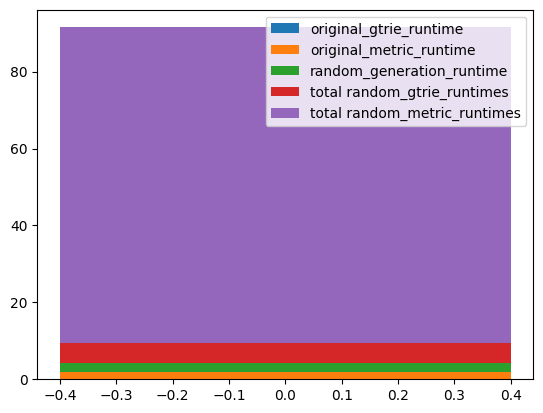

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

data = avg_benchmark_runs("yeastInter_st", 3)
del data["total_runtime"]
del data["avg random_gtrie_runtimes"]
del data["avg random_metric_runtimes"]

bottom = 0
for k, value in data.items():
    ax.bar(0, value, label=k, bottom=bottom)
    bottom += value
ax.legend()

In [7]:
"""Colelct Subgraph Counts to put context to runtimes"""
from tqdm import tqdm
import pandas as pd
from pathlib import Path

out4 = Path("../subgraph_size_4_counts.csv")
counts_df_4 = pd.read_csv(out4)
counts_df_4 = counts_df_4.set_index("Graph")

counts_df_4.at["human_cancer_cutoff_0.935", "Subgraph Count"] = 360658 + 338973 + 159215 + 24031 + 6799 + 3806
counts_df_4.at["human_brain_development_cutoff_0.772", "Subgraph Count"] = 252358 + 234582 + 109178 + 12972 + 4055 + 3196

out3 = Path("../subgraph_size_3_counts.csv")
counts_df_3 = pd.read_csv(out3)
counts_df_3 = counts_df_3.set_index("Graph")

counts_df_3.at["human_cancer_cutoff_0.935", "Subgraph Count"] = 32903 + 3437
counts_df_3.at["human_brain_development_cutoff_0.772", "Subgraph Count"] = 25155 + 2977

In [8]:
from statistics import stdev, mean


def get_dataframe(k: int):
    rows = []
    for dataset in DATASETS:
        try:
            data = avg_benchmark_runs(dataset, k)
            data["dataset"] = dataset
            data["subgraph_count_3"] = counts_df_3.at[dataset, "Subgraph Count"]
            data["subgraph_count_4"] = counts_df_4.at[dataset, "Subgraph Count"]
            rows.append(data)
        except KeyError as e:
            print(dataset, e)
            continue

    df = pd.DataFrame(rows).set_index("dataset")
    return df

mi_me_ma = lambda x: (min(x), mean(x), max(x), stdev(x))

In [9]:
def percent_original_random(k, ax=None):
    df = get_dataframe(k)

    df["percent_original"] = (df["original_gtrie_runtime"] + df["original_metric_runtime"]) / df["total_runtime"]
    df["percent_random"] = (df["total random_gtrie_runtimes"] + df["total random_metric_runtimes"]) / df["total_runtime"]
    df["percent_randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
    df = df[["percent_original", "percent_random", "percent_randomization"]].apply(mi_me_ma)
    return df, df[["percent_original", "percent_random", "percent_randomization"]].plot.box(
        title=f"${k}$-Graphlets",
        ax=ax
    )

yeastInter_st 'yeastInter_st'
   percent_original  percent_random  percent_randomization
0          0.016781        0.938564               0.003843
1          0.019313        0.960361               0.019974
2          0.022939        0.976538               0.038640
3          0.001616        0.011065               0.009729
2_scale_free_graph_a_28_b_7_g_02 'Random 2, graphlet_runtime'
0_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
1_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
yeastInter_st 'yeastInter_st'
4_scale_free_graph_a_28_b_7_g_02 'Random 1, graphlet_runtime'
3_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
   percent_original  percent_random  percent_randomization
0          0.015891        0.961791               0.000002
1          0.021059        0.978874               0.000020
2          0.038073        0.984095               0.000105
3          0.005538        0.005544               0.000020


/tmp/ipykernel_6676/1528465870.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


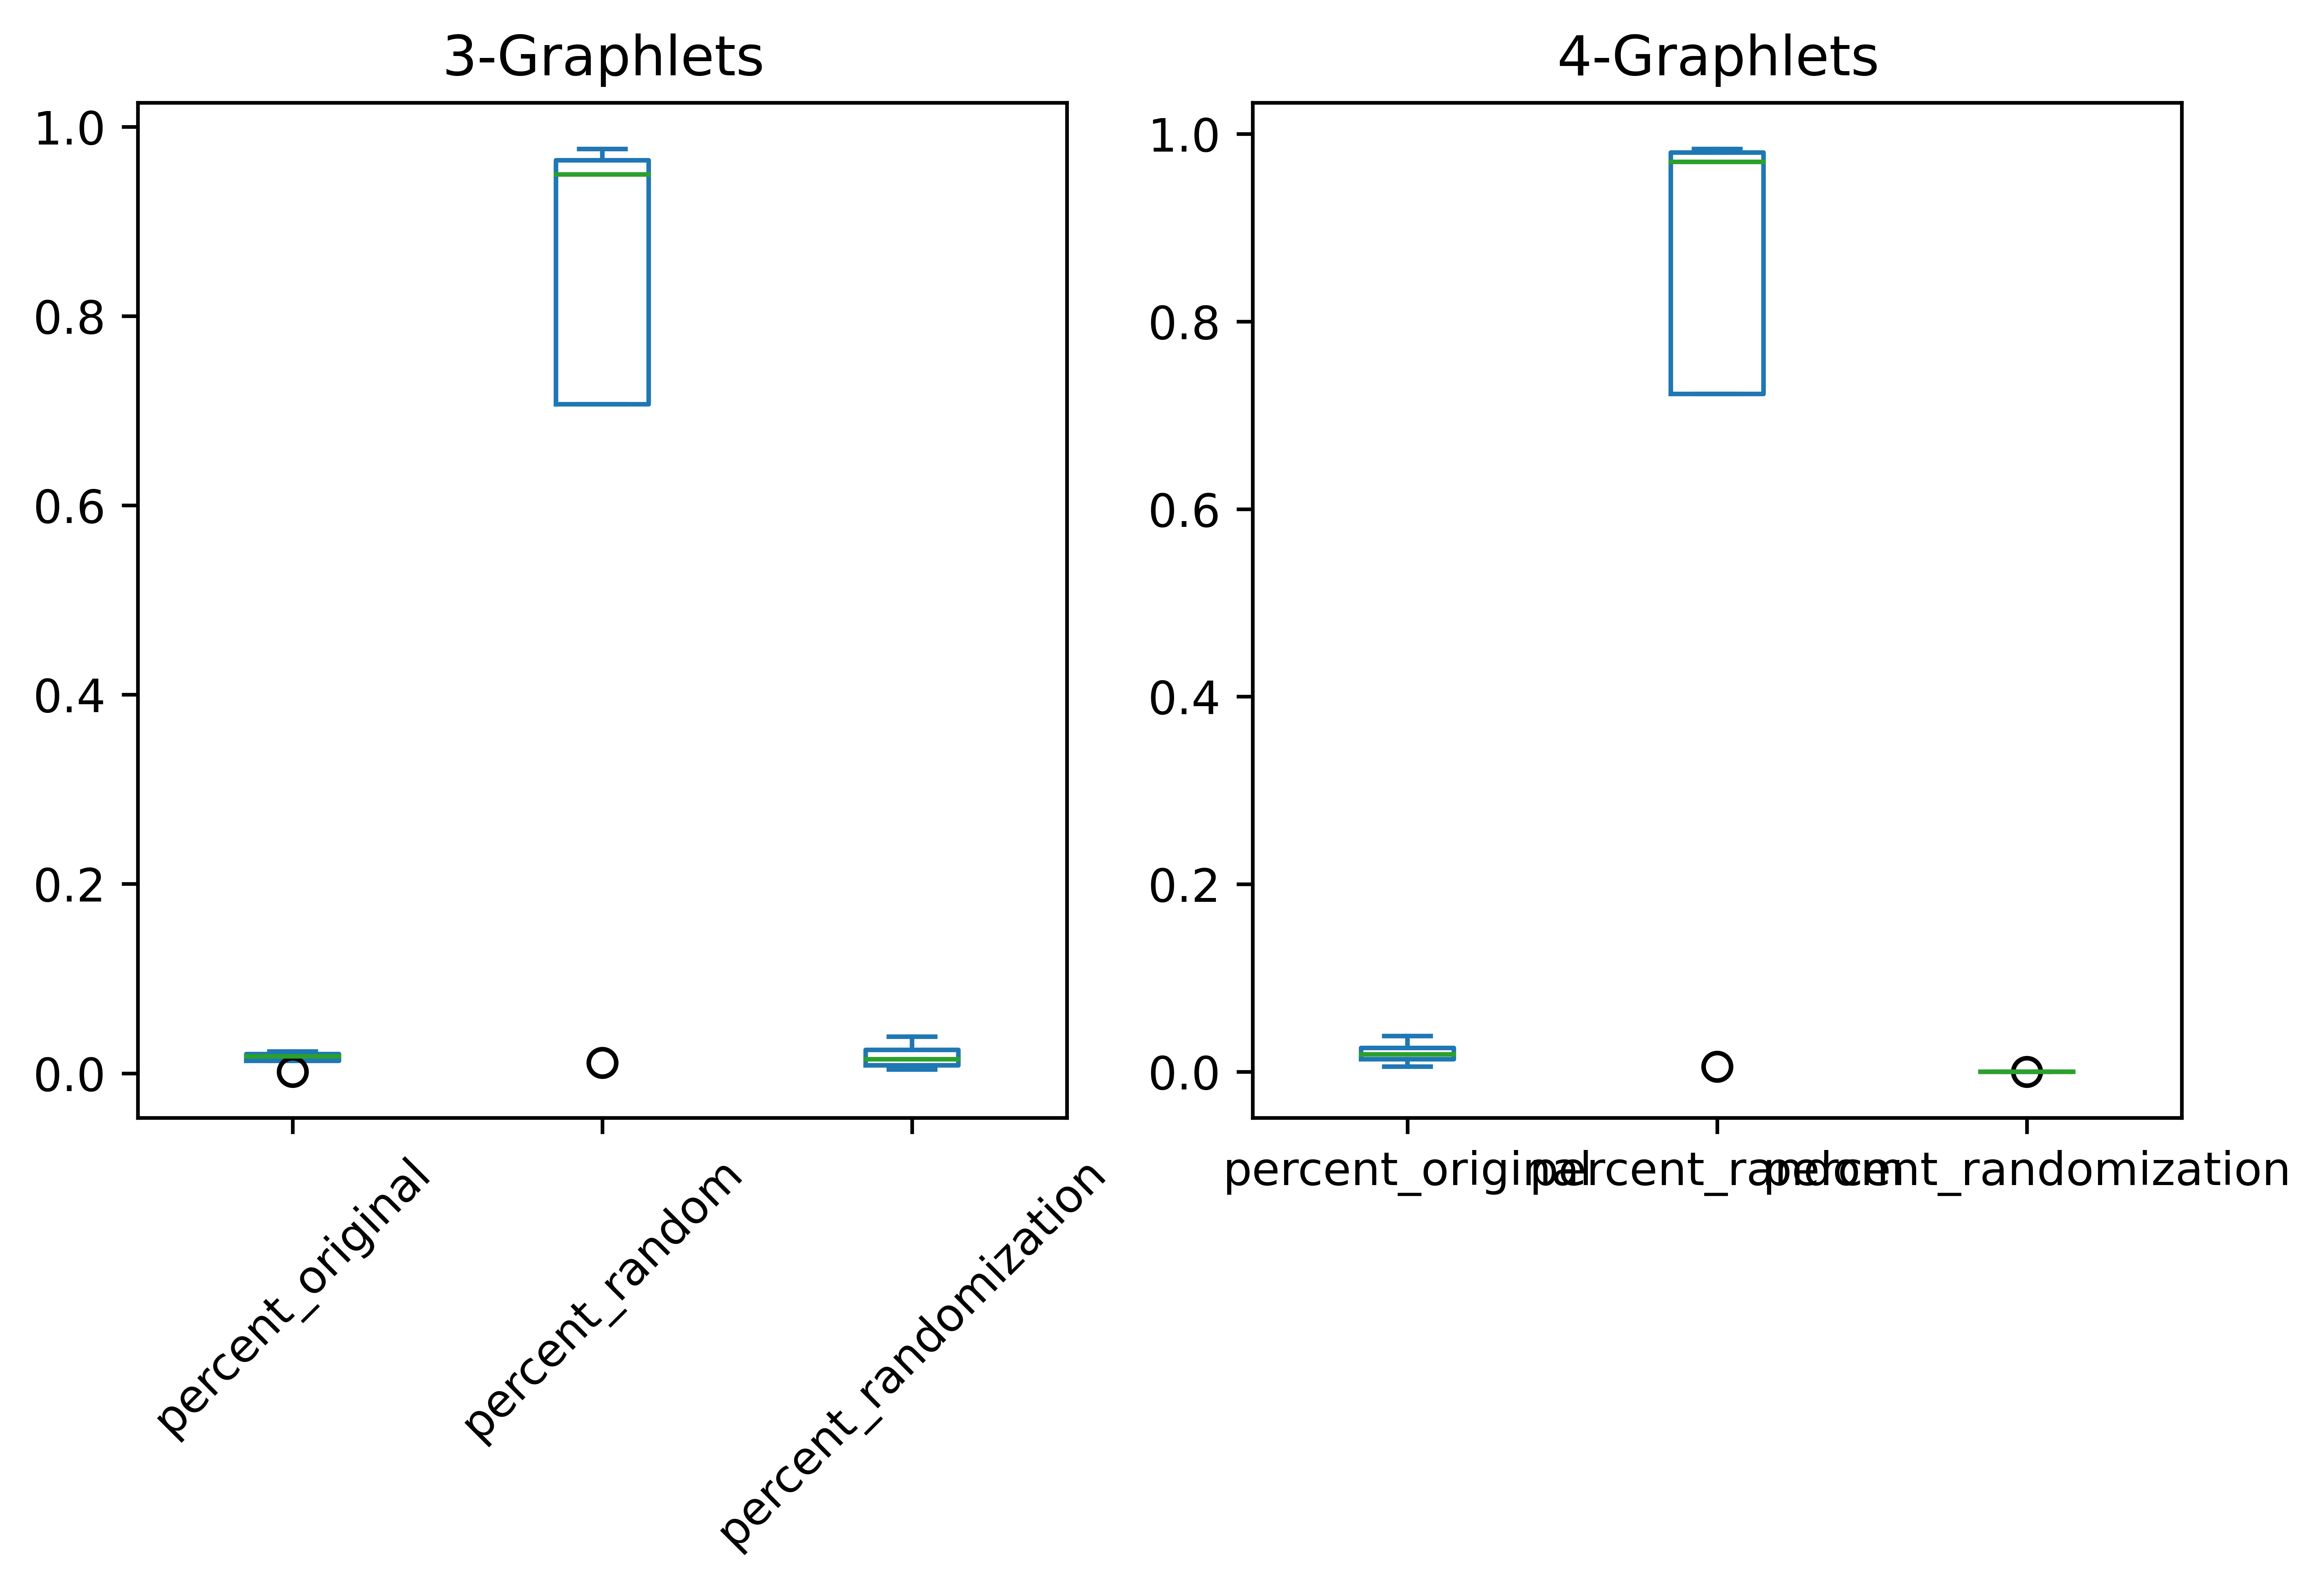

In [10]:
fig, (ax3, ax4) = plt.subplots(1,2, figsize=(8,4), dpi=1024)

print(percent_original_random(3, ax3)[0])
print(percent_original_random(4, ax4)[0])

ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

fig.show()

In [11]:
def percent_motif_pmotif(k, ax=None):
    df = get_dataframe(k)
    df["percent_graphlet"] = (df["original_gtrie_runtime"] + df["total random_gtrie_runtimes"]) / df["total_runtime"]
    df["percent_metric"] = (df["original_metric_runtime"] + df["total random_metric_runtimes"]) / df["total_runtime"]
    df["percent_randomization"] = (df["random_generation_runtime"]) / df["total_runtime"]
    df = df[["percent_randomization", "percent_graphlet", "percent_metric"]].apply(mi_me_ma)
    return df, df[["percent_randomization", "percent_graphlet", "percent_metric"]].plot.box(
        title=f"${k}$-Graphlets",
        ax=ax,
    )

yeastInter_st 'yeastInter_st'
   percent_randomization  percent_graphlet  percent_metric
0               0.003843          0.020988        0.907164
1               0.019974          0.046471        0.933203
2               0.038640          0.060029        0.960056
3               0.009729          0.011275        0.015937
2_scale_free_graph_a_28_b_7_g_02 'Random 2, graphlet_runtime'
0_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
1_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
yeastInter_st 'yeastInter_st'
4_scale_free_graph_a_28_b_7_g_02 'Random 1, graphlet_runtime'
3_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
   percent_randomization  percent_graphlet  percent_metric
0               0.000002          0.025742        0.932498
1               0.000020          0.051896        0.948037
2               0.000105          0.067440        0.974185
3               0.000020          0.013289        0.013290


/tmp/ipykernel_6676/3158574093.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


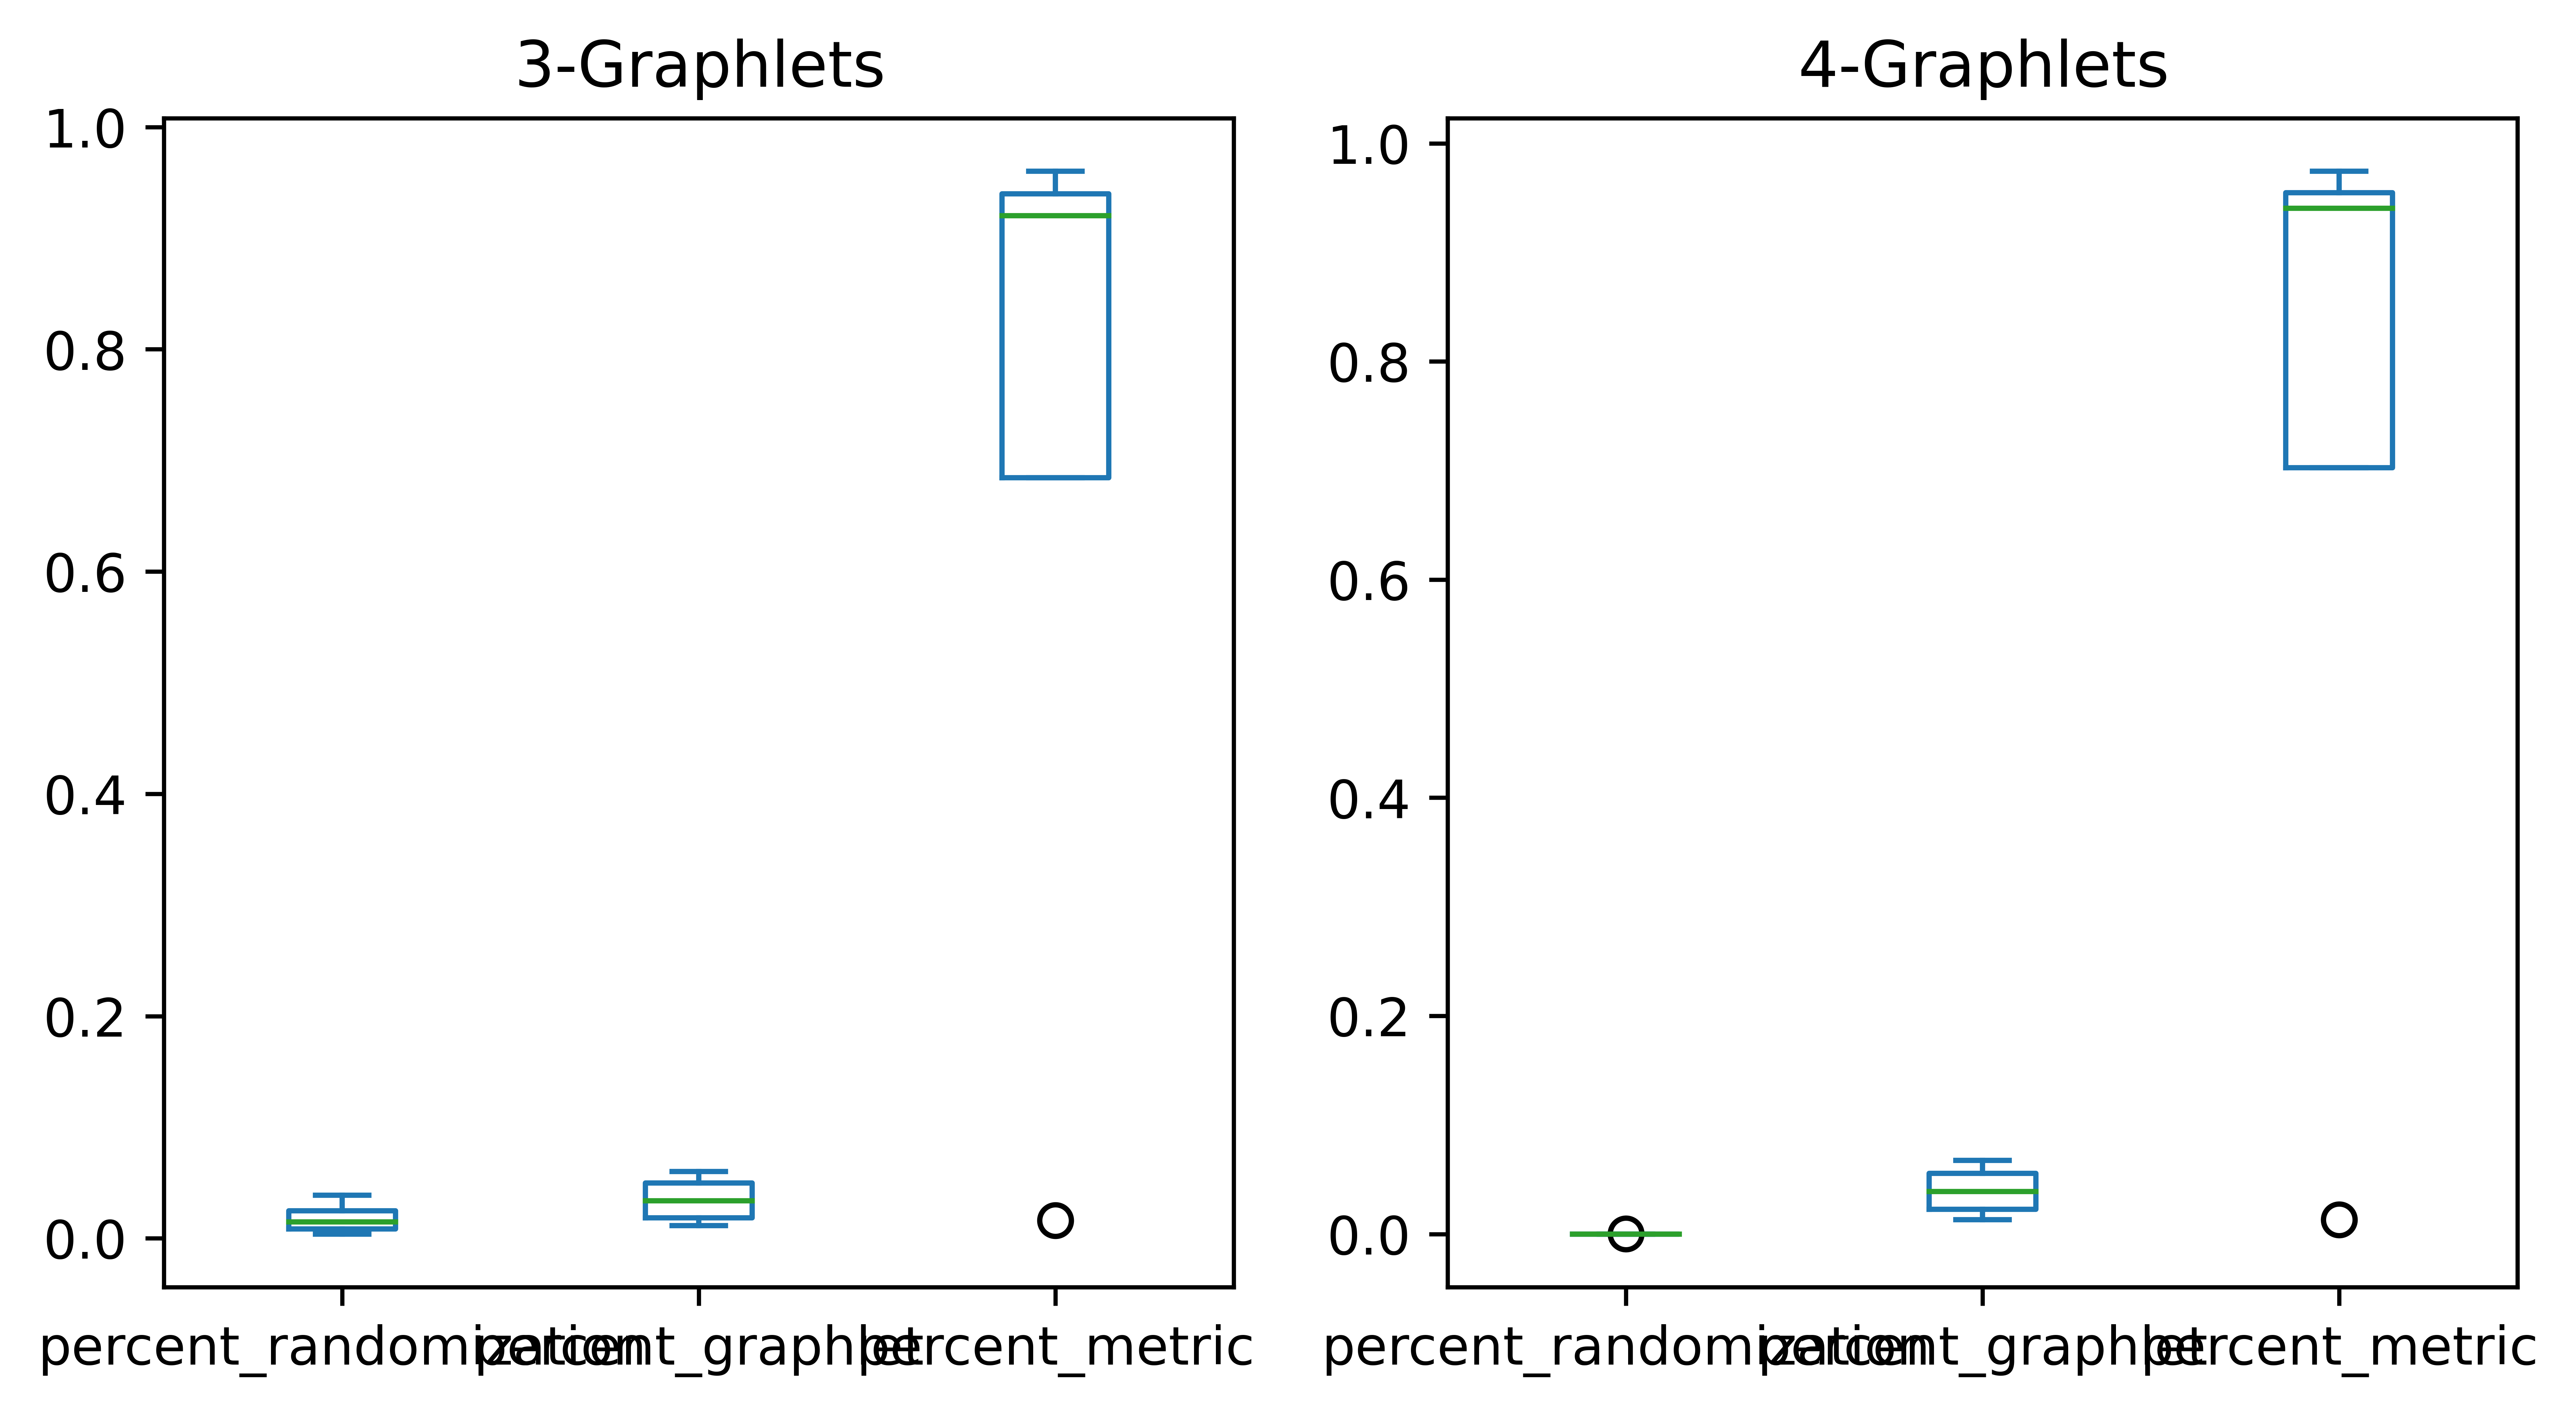

In [12]:
fig, (ax3, ax4) = plt.subplots(1,2, figsize=(8,4), dpi=1024)

print(percent_motif_pmotif(3, ax3)[0])
print(percent_motif_pmotif(4, ax4)[0])

fig.show()

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 18})

plt.rcParams['text.usetex'] = True

colors_for_graph_types = {
    'barabasi_albert_graph_m_1': 'tab:blue',
    'scale_free_graph_a_28_b_7_g_02': 'tab:orange',
    'scale_free_graph_a_35_b_3_g_35': 'tab:green',
    'ferdos_renyi_graph_m_2000': 'tab:red',
    'barabasi_albert_graph_m_3': 'tab:purple',
    'scale_free_graph_a_65_b_1_g_25': 'tab:brown',
    'barabasi_albert_graph_m_2': 'tab:pink',
    'brain_development_cutoff_0.772': "tab:grey",
    'cancer_cutoff_0.935' : 'tab:cyan',
 }

def graph_to_type(name: str):
    number, *rest = name.split("_")
    return "_".join(rest)


fig, (k3, k4) = plt.subplots(1,2, figsize=(14, 7), dpi=1024)


df = get_dataframe(3)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k3.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])

df = get_dataframe(4)
df["graph_type"] = list(map(graph_to_type, df.index))
for gt in set(df["graph_type"]):
    subgraph_count = df[df["graph_type"] == gt]["subgraph_count_4"]
    total_runtime = df[df["graph_type"] == gt]["total_runtime"]
    k4.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])

# Axis
k3.set_xlabel("Subgraph Count")
k4.set_xlabel("Subgraph Count")

k3.set_ylabel("Runtime (s)")
k4.set_ylabel("Runtime (s)")

k3.set_title(r"$3$-Graphlets")
k4.set_title(r"$4$-Graphlets")

k3.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
# Legend

import matplotlib.lines as mlines

label_lookup = {
    'barabasi_albert_graph_m_1': r"\textsc{Barabási-Albert} $m_1$",
    'barabasi_albert_graph_m_2': r"\textsc{Barabási-Albert} $m_2$",
    'barabasi_albert_graph_m_3': r"\textsc{Barabási-Albert} $m_3$",
    'ferdos_renyi_graph_m_2000': r"\textsc{Erdős–Rényi}",
    'scale_free_graph_a_28_b_7_g_02': r"\textsc{scale-free\textsubscript{28}",
    'scale_free_graph_a_35_b_3_g_35': r"\textsc{scale-free\textsubscript{35}",
    'scale_free_graph_a_65_b_1_g_25': r"\textsc{scale-free\textsubscript{25}",
    'brain_development_cutoff_0.772': r"\textsc{Human Brain}",
    'cancer_cutoff_0.935' : r"\textsc{Human Cancer}",
}

labels = []
handles = []

for graph_type, tex_label in label_lookup.items():
    
    labels.append(tex_label)
    handles.append(
        mlines.Line2D(
            [], [],
            color=colors_for_graph_types[graph_type],
            marker='o',
            linestyle='None',
            markersize=8,
            label=tex_label)
    )
k3.legend(labels=labels, handles=handles)

# INset
if False:
    axins = k3.inset_axes([0.5, 0.1, 0.47, 0.47])
    # Plot
    df = get_dataframe(3)
    df["graph_type"] = list(map(graph_to_type, df.index))
    for gt in set(df["graph_type"]):
        if gt == "scale_free_graph_a_28_b_7_g_02":
            continue
        subgraph_count = df[df["graph_type"] == gt]["subgraph_count_3"]
        total_runtime = df[df["graph_type"] == gt]["total_runtime"]
        axins.scatter(subgraph_count, total_runtime, label=gt, color=colors_for_graph_types[gt])

    # axins.imshow(Z2, extent=extent, origin="lower")
    # subregion of the original image

    k3.indicate_inset([-10**6, 0, 5 * 10 ** 6, 500], axins, edgecolor="black")

fig.tight_layout()

yeastInter_st 'yeastInter_st'
2_scale_free_graph_a_28_b_7_g_02 'Random 2, graphlet_runtime'
0_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
1_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'
yeastInter_st 'yeastInter_st'
4_scale_free_graph_a_28_b_7_g_02 'Random 1, graphlet_runtime'
3_scale_free_graph_a_28_b_7_g_02 'Random 0, graphlet_runtime'


In [14]:
fig.savefig("runtime_scatter.pdf")